# Imports #

In [10]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.model_selection import train_test_split

# EDA #

In [2]:
train_labels = pd.read_csv("data/train_images.csv")
test_samples = pd.read_csv("data/test_images_sample.csv")

class_names = np.load("data/class_names.npy", allow_pickle=True).item()

#print(train_labels.head())

for bird in list(class_names.keys()):
    print(bird)

001.Black_footed_Albatross
002.Laysan_Albatross
003.Sooty_Albatross
004.Groove_billed_Ani
005.Crested_Auklet
006.Least_Auklet
007.Parakeet_Auklet
008.Rhinoceros_Auklet
009.Brewer_Blackbird
010.Red_winged_Blackbird
011.Rusty_Blackbird
012.Yellow_headed_Blackbird
013.Bobolink
014.Indigo_Bunting
015.Lazuli_Bunting
016.Painted_Bunting
017.Cardinal
018.Spotted_Catbird
019.Gray_Catbird
020.Yellow_breasted_Chat
021.Eastern_Towhee
022.Chuck_will_Widow
023.Brandt_Cormorant
024.Red_faced_Cormorant
025.Pelagic_Cormorant
026.Bronzed_Cowbird
027.Shiny_Cowbird
028.Brown_Creeper
029.American_Crow
030.Fish_Crow
031.Black_billed_Cuckoo
032.Mangrove_Cuckoo
033.Yellow_billed_Cuckoo
034.Gray_crowned_Rosy_Finch
035.Purple_Finch
036.Northern_Flicker
037.Acadian_Flycatcher
038.Great_Crested_Flycatcher
039.Least_Flycatcher
040.Olive_sided_Flycatcher
041.Scissor_tailed_Flycatcher
042.Vermilion_Flycatcher
043.Yellow_bellied_Flycatcher
044.Frigatebird
045.Northern_Fulmar
046.Gadwall
047.American_Goldfinch
048.Eu

In [3]:
train_labels.sample(20)

,image_path,label
7,/train_images/8.jpg,1
571,/train_images/572.jpg,19
2102,/train_images/2103.jpg,74
1053,/train_images/1054.jpg,35
982,/train_images/983.jpg,33
2319,/train_images/2320.jpg,84
2714,/train_images/2715.jpg,102
1695,/train_images/1696.jpg,58
1124,/train_images/1125.jpg,38
451,/train_images/452.jpg,15


In [4]:
print(train_labels["label"].value_counts())

# Count of each class goes from 5 to 35
print("Min amount of times a class appears:", (train_labels["label"].value_counts()).min())
print("Max amount of times a class appears:", (train_labels["label"].value_counts()).max())

label
1      35
4      35
2      35
9      34
10     34
       ..
196     6
197     5
198     5
199     5
200     5
Name: count, Length: 200, dtype: int64
Min amount of times a class appears: 5
Max amount of times a class appears: 35


In [5]:
train_labels['class_name'] = train_labels['label'].map(
    {v: k for k, v in class_names.items()}  # Reverse the dictionary to map label to class_name
)

train_labels['class_name'] = [
    "_".join(name.split('.')[1].split('_')) for name in train_labels['class_name']
]

train_labels['image_path'] = 'data' + train_labels['image_path']
train_labels

,image_path,label,class_name
0,data/train_images/1.jpg,1,Black_footed_Albatross
1,data/train_images/2.jpg,1,Black_footed_Albatross
2,data/train_images/3.jpg,1,Black_footed_Albatross
3,data/train_images/4.jpg,1,Black_footed_Albatross
4,data/train_images/5.jpg,1,Black_footed_Albatross
...,...,...,...
3921,data/train_images/3922.jpg,200,Common_Yellowthroat
3922,data/train_images/3923.jpg,200,Common_Yellowthroat
3923,data/train_images/3924.jpg,200,Common_Yellowthroat
3924,data/train_images/3925.jpg,200,Common_Yellowthroat


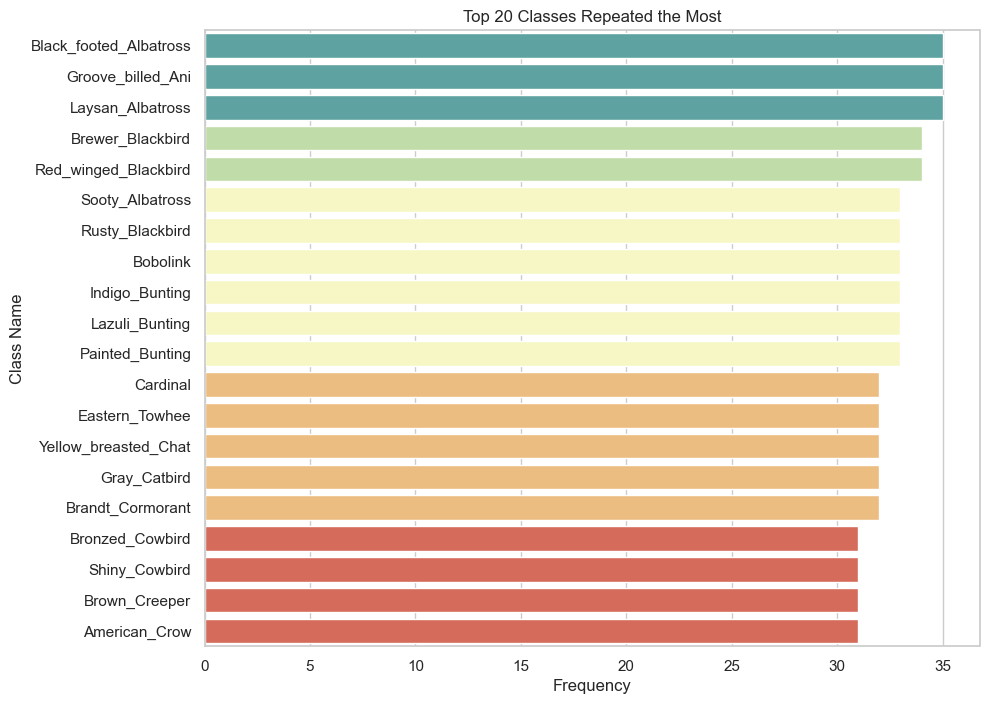

In [6]:
# Let's check beautifully which are the top 20 most repeated bird classes
top_20 = (train_labels['class_name'].value_counts()[:20])

color_palette = sns.color_palette("Spectral", len(set(top_20.values)))
frequency_to_color = {freq: color for freq, color in zip(sorted(set(top_20.values)), color_palette)}
bar_colors = [frequency_to_color[freq] for freq in top_20.values]

sns.set(style="whitegrid")

plt.figure(figsize=(10, 8))
sns.barplot(
    x=top_20.values,
    y=top_20.index,
    palette=bar_colors
)
plt.xlabel("Frequency")
plt.ylabel("Class Name")
plt.title("Top 20 Classes Repeated the Most")
plt.show()

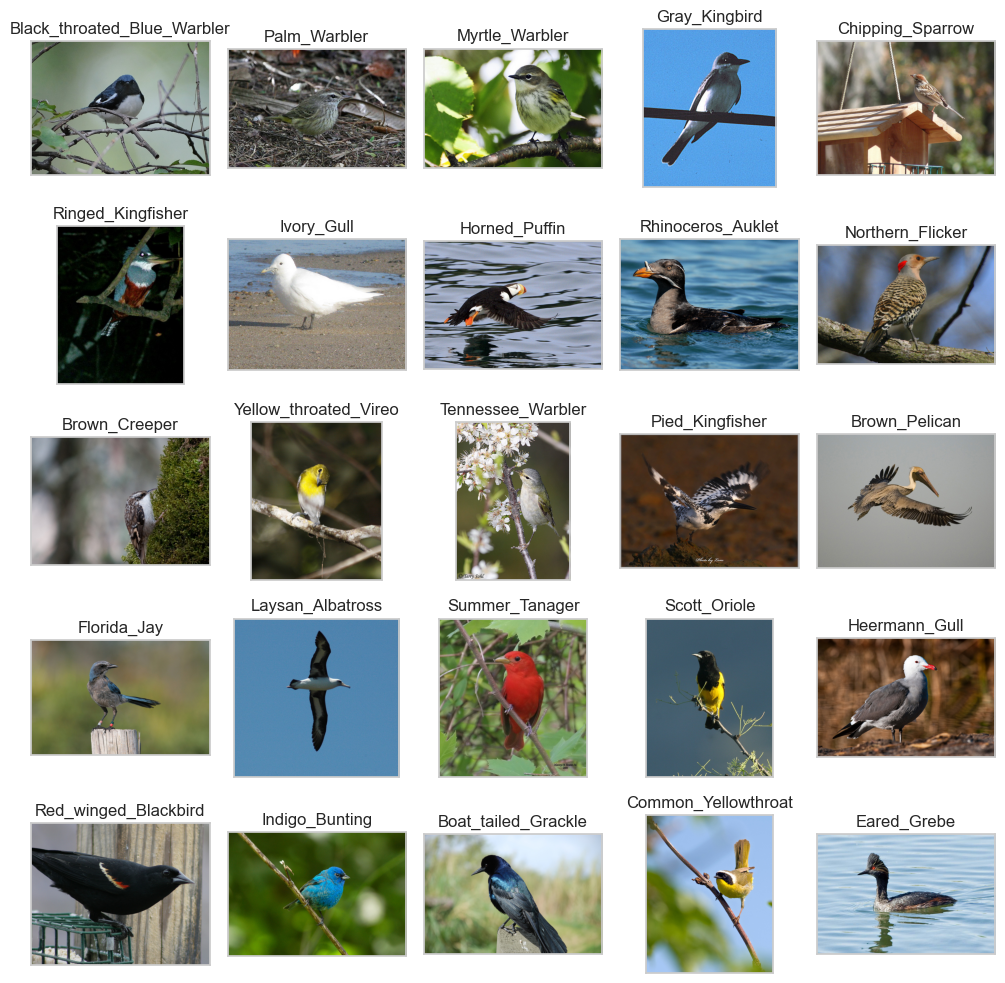

In [7]:
sample_df = train_labels.sample(25)

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10), 
                         subplot_kw={'xticks': [], 'yticks': []})

for ax, (_, row) in zip(axes.flat, sample_df.iterrows()):
    ax.imshow(plt.imread(row['image_path']))
    ax.set_title(row['class_name'])

plt.tight_layout()
plt.show()

# Data Processing #

In [11]:
# train_df, test_df = train_test_split(train_labels, test_size=0.2, shuffle=True, random_state=42)

image_paths = train_labels['image_path'].apply(lambda x: './data/train_images/' + x).values
labels = train_labels['label'].values

# 80% train, 20% validation
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

In [14]:
def resize_normalize(image_path, label):
    # loading image
    image = tf.io.read_file(image_path)
    # jpg image to tensor so that it can be processed by TensorFlow
    image = tf.image.decode_jpeg(image, channels=3)
    # resizing all images for further processing
    image = tf.image.resize(image, [224, 224])
    # pixel normalisation for reproducibility and learning general patterns
    image = image / 255.0

    return image, label

def augmentation(image_path, label):
    # horizontal flip
    image = tf.image.random_flip_left_right(image)
    # brightness adjustment
    image = tf.image.random_brightness(image, max_delta=0.2) 
    # contrast adjustment
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  
    # zooming (?)
    # image = tf.image.random_zoom(image, [0.9, 1.1])

    return image, label